# No More Alzheimer's Disease

## General Data Processing

### Data Downloading

In [50]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

### SVM Approach

Use Cross Validation to find what parameters suit this problem the best

In [51]:
%reload_ext autoreload
%autoreload 2
from Classifiers import MySVM

Best Parameters:  {'C': 1, 'decision_function_shape': 'ovr', 'degree': 3, 'kernel': 'poly'}
Best Score:  0.704164877629884


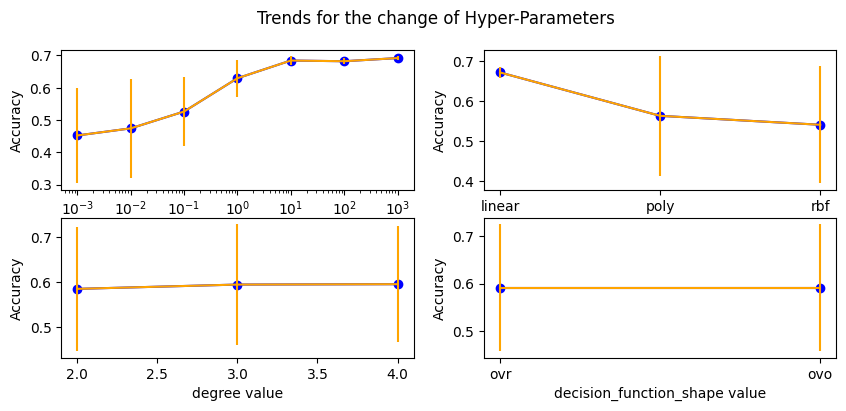

In [52]:
svm1_withoutliers = MySVM("Data/PreProcessedData/Outliers/File1.csv", ['RID', 'VISCODE'])
svm1_withoutliers.hyper_parameter_selection()

Best Parameters:  {'C': 1000, 'decision_function_shape': 'ovr', 'degree': 4, 'kernel': 'poly'}
Best Score:  0.7030812324929973


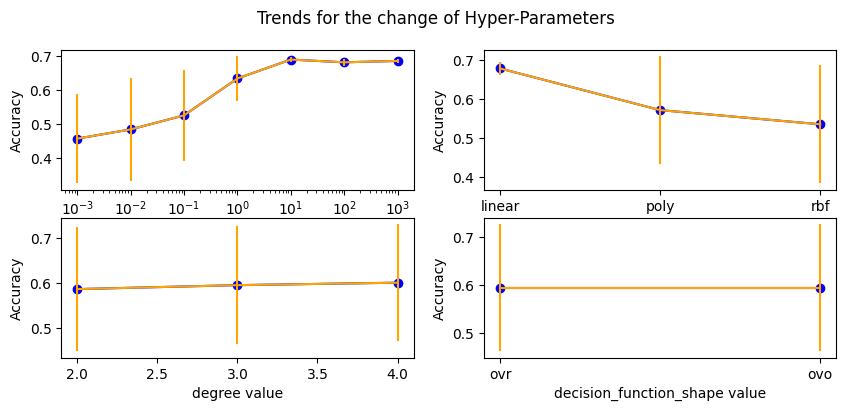

In [53]:
svm1_withoutoutliers = MySVM("Data/PreProcessedData/OutliersRemoved/File1.csv", ['RID', 'VISCODE'])

svm1_withoutoutliers.hyper_parameter_selection()

## Test for these hyper-parameters

In [56]:
svm1_withoutoutliers.test(True)

Accuracy is 0.6111111111111112
+-----------+-------+----------+----------+
|           |   SCD |      MCI |       AD |
+===========+=======+==========+==========+
| Recall    |   0.8 | 0.458333 | 0.516129 |
+-----------+-------+----------+----------+
| Precision |   0.8 | 0.333333 | 0.727273 |
+-----------+-------+----------+----------+
| F1 Score  |   0.8 | 0.385965 | 0.603774 |
+-----------+-------+----------+----------+


### Binary Decision Tree SVM Classifier

# Random Forest Approach

In [3]:
%reload_ext autoreload
%autoreload 2
from Classifiers import MyRF

Computing Results.......
Best Parameters:  {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'n_estimators': 200}
Best Score:  0.7213038500071561


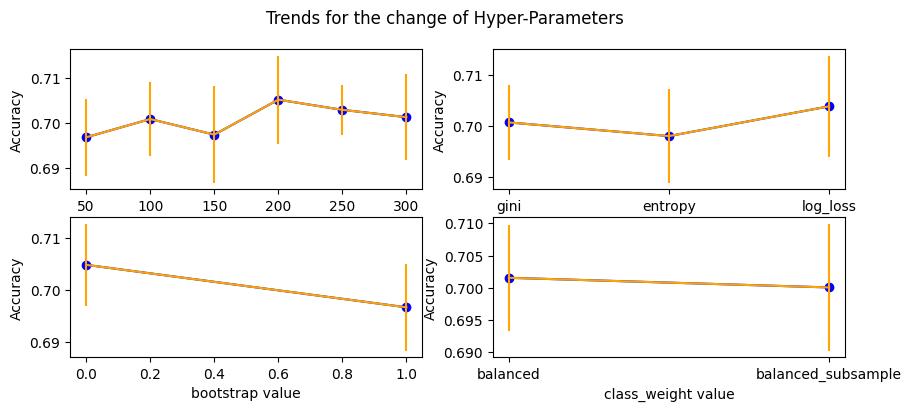

In [5]:
# Before Removing Outliers
print("Computing Results.......")
rf1 = MyRF("Data/PreProcessedData/Outliers/File1.csv", ['RID', 'VISCODE'])
rf1.hyper_parameter_selection()

In [6]:
# Display the test results for this data
rf1.test(True)

Accuracy is 0.7281553398058253
+-----------+----------+----------+----------+
|           |      SCD |      MCI |       AD |
+===========+==========+==========+==========+
| Recall    | 0.828571 | 0.611111 | 0.75     |
+-----------+----------+----------+----------+
| Precision | 0.828571 | 0.628571 | 0.727273 |
+-----------+----------+----------+----------+
| F1 Score  | 0.828571 | 0.619718 | 0.738462 |
+-----------+----------+----------+----------+


## Handling the minority class of AD

Upon inspection of the data set, AD is a very under-represented group in the dataset.

### Data distribution visualisation

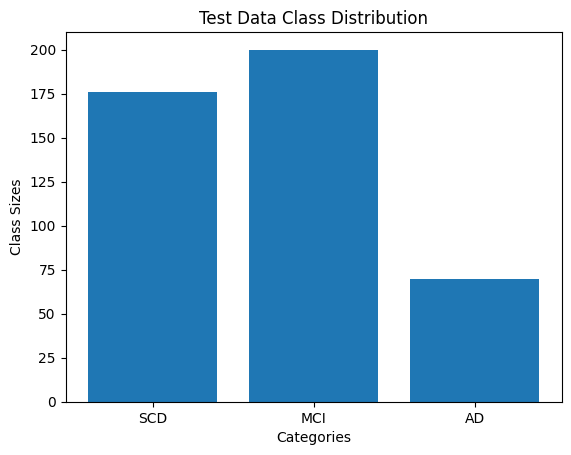

In [ ]:
# Read the dataset
df = pd.read_csv("Data/ProcessedData/PLASMA_MERGED.csv")

# Display the size of each of the groups
sizes = [len(df[df["DX"] == "SCD"]), len(df[df["DX"] == "MCI"]), len(df[df["DX"] == "AD"])]

# Represent as a graph
categories = ["SCD", "MCI", "AD"]
plt.bar(categories, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Test Data Class Distribution')
plt.show()


### SMOTE Oversampling

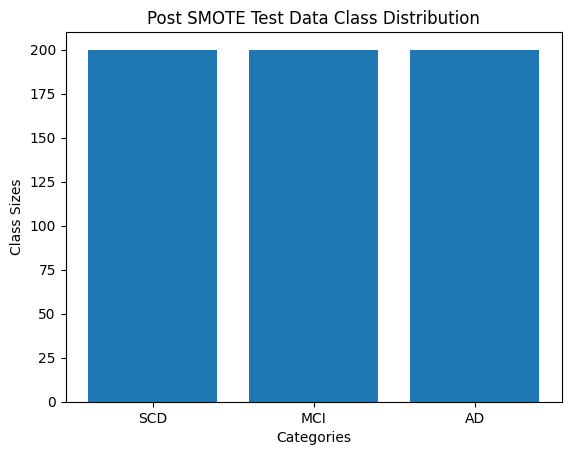

In [ ]:
# Use SMOTE :: SOURCE (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8125820)
    # Extra complexity not necessary for this case
# How to implement SMOTE (https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688)

sm = SMOTE(random_state=42)

X, y = getXy(df)

# Oversample the minority classes
X, y = sm.fit_resample(X, y)


# Display the size of each of the groups
sizes = [np.count_nonzero(y == "SCD"), np.count_nonzero(y == "MCI"), np.count_nonzero(y == "AD")]

# Represent as a graph
categoroies = ["SCD", "MCI", "AD"]
plt.bar(categoroies, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Post SMOTE Test Data Class Distribution')
plt.show()


## Test Data Model

In [ ]:
# This re-associates the features with the labels
df = pd.DataFrame(data=np.column_stack((X, y)), columns=list(df.drop("DX", axis=1).columns) + ["DX"])

# Get X and y
X, y = getXy(df)

print("Best Parameters " + str(grid_search.best_params_))

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42, # Ensure reproducibility
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)
# Calculate the training error
y_trainresult = test_classifier.predict(X_train)

# Print the test results
print("\nTesting accuracy is " + str(accuracy_score(y_test, y_testresult)))
print("Training accuracy is " + str(accuracy_score(y_train, y_trainresult)))

# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))

print()
# Get all of the data in array forms
data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

print("TEST ACCURACY")
table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt="grid")
print(table)



Best Parameters {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 100}

Testing accuracy is 0.9916666666666667
Training accuracy is 1.0

TEST ACCURACY
+-----------+----------+----------+------+
|           |      SCD |      MCI |   AD |
+===========+==========+==========+======+
| Recall    | 0.977273 | 1        |    1 |
+-----------+----------+----------+------+
| Precision | 1        | 0.978261 |    1 |
+-----------+----------+----------+------+
| F1 Score  | 0.988506 | 0.989011 |    1 |
+-----------+----------+----------+------+


## Feature Importance

Text(0, 0.5, 'Relative Importance')

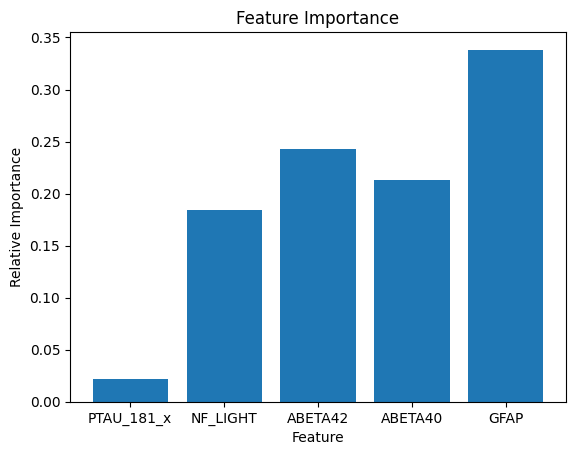

In [ ]:
# Get the importance of each feature in this classifier
importances = test_classifier.feature_importances_

# Now plot these
plt.bar(df.columns[:-1], importances)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")

## Create a master file

In [ ]:
# Read the two files involved

plasma = pd.read_csv("Data/ProcessedData/ALL_PLASMA_MERGED.csv")

# Merge based on VISCODE
plasma

,RID,PLASMA_NFL,PTAU_181_x,NF_LIGHT,ABETA42,ABETA40,GFAP,PTAU_181_y,AB40,AB42,DX
0,2,28.2,NaN,NaN,NaN,NaN,NaN,NaN,153.7,50.9,SCD
1,3,188.3,NaN,NaN,NaN,NaN,NaN,NaN,263.3,58.1,AD
2,4,31.2,NaN,NaN,NaN,NaN,NaN,NaN,192.0,59.8,MCI
3,5,36.3,NaN,NaN,NaN,NaN,NaN,NaN,246.1,46.7,SCD
4,6,52.5,NaN,NaN,NaN,NaN,NaN,NaN,289.0,44.3,MCI
...,...,...,...,...,...,...,...,...,...,...,...
6702,1409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.1,33.0,AD
6703,1417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.9,40.0,MCI
6704,1423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.5,32.4,AD
6705,1426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.2,38.4,MCI


## Sparse Data Selection

In [ ]:
# SOURCE :: https://ro.ecu.edu.au/cgi/viewcontent.cgi?article=1654&context=ecuworkspost2013
#           https://www.kaggle.com/code/adizafar/feature-selection-using-genetic-algorithm

# Get the plasma data and merge it with the ADNI data.
plasma = pd.read_csv("Data/ProcessedData/ALL_PLASMA_WVC.csv")
adni = pd.read_csv("Data/ProcessedData/ADNIMerge_WVC.csv")

# Now merge the data together
df = adni.merge(plasma, how = "outer")
# Drop unnamed column
df = df.drop(df.columns[df.columns.str.contains('^Unnamed')], axis=1)

df.to_csv("Data/ProcessedData/FeatureSelectionData.csv", index = False)


In [ ]:
# Read the entire CSV
df = pd.read_csv("Data/ProcessedData/FeatureSelectionData.csv")
df.drop(["VISCODE", "RID"], inplace = True, axis = 1)

df.fillna(0, inplace = True)

# Convert to sparse matrix
X, y = getXy(df)
X = csr_matrix(X)

# Train the random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
# Create the test object
rf = RandomForestClassifier()

# Re-read the dataframe
X, y = getXy(df)

print(X)

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we create the grid of params we need to test
param_grid = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap' : [True, False],
    'class_weight' : ['balanced', 'balanced_subsample']
}

# Create the test Object and fit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

[[ 20.    81.3   22.83 ...   0.     0.     0.  ]
 [ 17.    81.3   24.18 ...   0.     0.     0.  ]
 [ 27.    67.5   13.29 ...   0.     0.     0.  ]
 ...
 [  0.     0.     0.   ...   0.   143.5   32.4 ]
 [  0.     0.     0.   ...   0.   153.2   38.4 ]
 [  0.     0.     0.   ...   0.   142.9   37.9 ]]


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'n_estimators': 200}
0.4811905746176106


In [ ]:
# Test with these hyper-parameters
# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42, # Ensure reproducibility
)

# Fit the classifier
test_classifier.fit(X_train, y_train)

# Predict what these classes should be
y_pred = test_classifier.predict(X_test)

# Get the accuracy measures
# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))

print()
# Get all of the data in array forms
data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

# Print the table
print("TEST ACCURACY : " + str(accuracy_score(y_test, y_pred)))
table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt = "grid")
print(table)




TEST ACCURACY : 0.474931129476584
+-----------+----------+----------+----------+
|           |      SCD |      MCI |       AD |
+===========+==========+==========+==========+
| Recall    | 0.429253 | 0.532819 | 0.435208 |
+-----------+----------+----------+----------+
| Precision | 0.475352 | 0.502427 | 0.420804 |
+-----------+----------+----------+----------+
| F1 Score  | 0.451128 | 0.517177 | 0.427885 |
+-----------+----------+----------+----------+


Text(0, 0.5, 'Relative Importance')

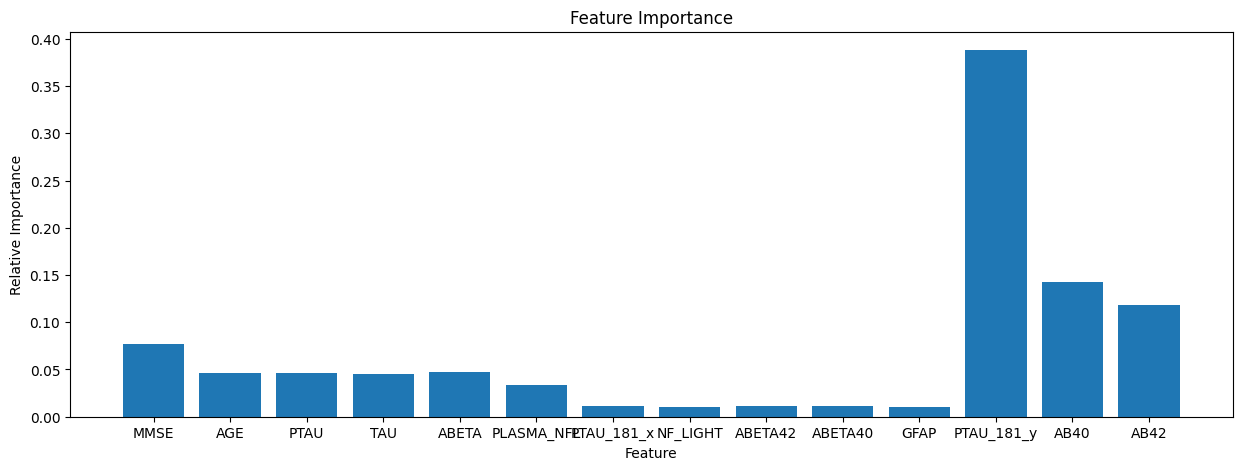

In [ ]:
# Feature importance
# Get the importance of each feature in this classifier
importances = test_classifier.feature_importances_

plt.figure(figsize=(15, 5))

# Now plot these
plt.bar(df.columns[1:], importances)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")

In [ ]:
# TODO :: Do Feature Selection
# TODO :: Investigate about data sizes affecting graph above
# TODO :: Make sure all patients are seperate